In [1]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 19.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 20.8 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.1/330.1 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.6/755.6 MB 10.4 MB/s eta 0:00:0000:0100:02
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 13.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 15.9 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 13.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 5.5 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 13.9 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 12.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import Compose, ToTensor, Normalize
import torchvision.transforms.v2 as transforms
from PIL import Image
from tqdm import tqdm
from typing import Tuple, Union, Any
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from torchvision.models import detection
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Utils functions
def set_seed(seed: int) -> None:
    """
    Define a seed for reproducibility. It allows experiment repetition obtaining the exact same results.
    :param seed: integer number indicating which seed you want to use.
    :return: None.
    """
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    np.random.seed(seed)  # Numpy module.
    # random.seed(seed)  # Python random module.
    torch.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

def get_inner_model(model: detection) -> Any:
    """
    PyTorch provides a model wrapper to enable multiple GPUs. This function returns the inner model (without wrapper).
    :param model: Torch model, with or without nn.DataParallel wrapper.
    :return: if model is wrapped, it returns the inner model (model.module). Otherwise, it returns the input model.
    """
    return model.module if isinstance(model, torch.nn.DataParallel) else model

def torch_load_cpu(load_path: str) -> Any:
    """
    Load the data saved from a trained model (model weights, optimizer state, last epoch number to resume training...)
    :param load_path: string indicating the path to the data saved from a trained model.
    :return: dictionary containing data saved from a trained model.
    """
    return torch.load(load_path, map_location=lambda storage, loc: storage)  # Load on CPU

def load_model_path(path: str, model: detection, device: torch.device, optimizer: torch.optim = None) -> Tuple[Any, Any, int]:
    """
    Load the trained weights of a model into the given model.
    :param path: string indicating the path to the trained weights of a model.
    :param model: the model where you want to load the weights.
    :param device: whether gpu or cpu is being used.
    :param optimizer: the optimizer initialized before loading the weights.
    :return:
        model: Torchvision model.
        optimizer: Torch optimizer.
        initial_epoch: first epoch number.
    """

    # Load model state
    load_data = torch_load_cpu(path)
    model_ = get_inner_model(model)
    model_.load_state_dict({**model_.state_dict(), **load_data.get('model', {})})

    # Load rng state
    torch.set_rng_state(load_data['rng_state'])
    if torch.cuda.is_available():
        torch.cuda.set_rng_state_all(load_data['cuda_rng_state'])

    # Load optimizer state
    if 'optimizer' in load_data and optimizer is not None:
        optimizer.load_state_dict(load_data['optimizer'])
        for state in optimizer.state.values():
            for k, v in state.items():
                if torch.is_tensor(v):
                    state[k] = v.to(device)

    # Get initial epoch
    initial_epoch = load_data['initial_epoch']

    return model, optimizer, initial_epoch
def torchvision_model(model_name: str, pretrained: bool = False, num_classes: int = 2) -> Any:
    """
    Return a model from a list of Torchvision models.
    :param model_name: name of the Torchvision model that you want to load.
    :param pretrained: whether pretrained weights are going to be loaded or not.
    :param num_classes: number of classes. Minimum is 2: 0 = background, 1 = object.
    :return:
        model: Torchvision model.
    """

    # Torchvision models
    model_dict = {
        'faster_rcnn_v1': detection.fasterrcnn_resnet50_fpn,
        'faster_rcnn_v2': detection.fasterrcnn_resnet50_fpn_v2,
        'faster_rcnn_v3': detection.fasterrcnn_mobilenet_v3_large_fpn,
        # 'faster_rcnn_v4': detection.fasterrcnn_mobilenet_v3_large_320_fpn,
        # 'fcos_v1': detection.fcos_resnet50_fpn,
        'retinanet_v1': detection.retinanet_resnet50_fpn,
        'retinanet_v2': detection.retinanet_resnet50_fpn_v2,
        'ssd_v1': detection.ssd300_vgg16,
        'ssd_v2': detection.ssdlite320_mobilenet_v3_large,
    }

    # Create model and load pretrained weights (if pretrained=True)
    if model_name in model_dict:
        model = model_dict[model_name](weights='COCO_V1' if pretrained else None)

        # Modify the model's output layer for the number of classes in your dataset
        if 'faster_rcnn' in model_name:
            in_features = model.roi_heads.box_predictor.cls_score.in_features
            model.roi_heads.box_predictor = detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)
        elif 'retinanet' in model_name:
            in_features = model.head.classification_head.cls_logits.in_channels
            num_anchors = model.head.classification_head.num_anchors
            model.head.classification_head = detection.retinanet.RetinaNetClassificationHead(
                in_features, num_anchors, num_classes
            )
        elif 'fcos' in model_name:
            in_features = model.head.classification_head.cls_logits.in_channels
            num_anchors = model.head.classification_head.num_anchors
            model.head.classification_head = detection.fcos.FCOSClassificationHead(
                in_features, num_anchors, num_classes
            )
        elif 'ssd_v1' in model_name:
            in_features = [module.in_channels for module in model.head.classification_head.module_list]
            num_anchors = model.anchor_generator.num_anchors_per_location()
            model.head.classification_head = detection.ssd.SSDClassificationHead(
                in_features, num_anchors, num_classes
            )
        elif 'ssd_v2' in model_name:
            in_features = [module[0][0].in_channels for module in model.head.classification_head.module_list]
            num_anchors = model.anchor_generator.num_anchors_per_location()
            model.head.classification_head = detection.ssd.SSDClassificationHead(
                in_features, num_anchors, num_classes
            )

    # Error: Model not in list
        else:
            assert False, 'Model {} not in list. Indicate a Torchvision model from the list.'.format(model_name)
    else:
        assert False, 'Model {} not in list. Indicate a Torchvision model from the list.'.format(model_name)

    return model

def get_model(model_name: str, model_path: str = '', num_classes: int = 2,
              lr_data: list = None, pretrained: bool = False,
              use_gpu: bool = False) -> Tuple[Any, Any, int, torch.device]:
    """
    Main function to create and load the model.
    :param model_name: name of the Torchvision model to load.
    :param model_path: path to the model.
    :param num_classes: number of classes. Minimum is 2: 0 = background, 1 = object.
    :param lr_data: list containing [learning rate, learning rate momentum, learning rate decay].
    :param pretrained: whether Torch pretrained weights on COCO dataset are going to be used or not.
    :param use_gpu: whether to use GPU or CPU.
    :return:
        model: Torch model.
        optimizer: Torch optimizer.
        initial_epoch: first epoch number.
        device: torch device indicating whether to use GPU or CPU.
    """

    # Define device (GPU or CPU)
    device_name = 'cuda' if use_gpu and torch.cuda.is_available() else 'cpu'
    device = torch.device(device_name)

    # Load Torchvision model
    model = torchvision_model(model_name, pretrained, num_classes).to(device)
    if use_gpu and torch.cuda.is_available() and torch.cuda.device_count() > 1:
        model = torch.nn.DataParallel(model).cuda()

    # Define the optimizer
    if lr_data:
        params = [p for p in model.parameters() if p.requires_grad]
        optimizer = torch.optim.SGD(params, lr=lr_data[0], momentum=lr_data[1], weight_decay=lr_data[2])
        # optimizer = torch.optim.Adadelta(params, lr=lr_data[0], rho=lr_data[1], eps=lr_data[2])
    else:
        optimizer = None

    # Load trained weights, optimizer state, and initial epoch
    if os.path.isfile(model_path):
        print('  [*] Loading Torch model from {}'.format(model_path))
        model, optimizer, initial_epoch = load_model_path(model_path, model, device, optimizer)
    else:
        initial_epoch = 0
        print('Weights not found')

    return model, optimizer, initial_epoch, device

def clip_grad_norms(param_groups, max_norm=np.inf) -> Tuple[list, list]:
    """
    Limit (clip) the norm of the gradients to avoid gradient explosion.
    :param param_groups: parameters of the optimizer, from which gradients are extracted.
    :param max_norm: maximum value for the norm of the gradient. max_norm = 0 avoids clipping.
    :return:
        grad_norms: gradients.
        grad_norms_clipped: clipped gradients.
    """
    # Get gradients
    grad_norms = [
        torch.nn.utils.clip_grad_norm_(
            group['params'],
            max_norm if max_norm > 0 else np.inf,  # Inf so no clipping but still call to calc
            norm_type=2
        )
        for group in param_groups
    ]

    # Clip gradients
    grad_norms_clipped = [min(g_norm, max_norm) for g_norm in grad_norms] if max_norm > 0 else grad_norms
    return grad_norms, grad_norms_clipped


In [3]:
# Data functions
class CustomDataset(Dataset):

    def __init__(self, path_dataset: str, resize_shape: tuple = None, transform: transforms.Compose = None) -> None:
        """
        Custom dataset that feeds the network during train, validation, and test.
        :param path_dataset: path to the dataset.
        :param resize_shape: tuple indicating height and width to resize images (for faster performance).
        :param transform: list of transforms to apply to the images.
        """
        self.annotations = parse_annotations(path_dataset)
        self.resize_shape = resize_shape
        self.transform = transform

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, dict]:
        """
        Get an index corresponding to one of the images and return the image and its annotation.
        :param idx: index of image to load.
        :return:
            image: Torch tensor containing the image with shape (Channels, Height, Width).
            targets: dictionary with the bounding boxes (boxes) and class labels (labels) of each annotated object.
        """
        # Get one annotation for the current index
        annotation = self.annotations[idx]

        # Load image
        image = Image.open(annotation['path_image']).convert("RGB")

        # Load bounding boxes
        boxes = self.annotations[idx]['boxes']
        boxes = torch.Tensor(boxes)

        # Load labels (class of the object)
        labels = self.annotations[idx]['labels']
        labels = torch.Tensor(labels).type(torch.int64)  # Specify that labels are int

        # Apply transforms
        if self.transform:
            w, h = image.size
            image, boxes, class_labels = self.transform(image, boxes, labels)
            if self.resize_shape:
                boxes = resize_boxes(boxes, self.resize_shape, (h, w))

        # Torchvision models use this structure for boxes and labels
        targets = {'boxes': boxes, 'labels': torch.Tensor(labels)}

        return image, targets

    def __len__(self) -> int:
        """
        Length of the dataset.
        :return: number of annotated images contained in the dataset.
        """
        return len(self.annotations)


def resize_boxes(boxes: torch.Tensor, resize_shape: tuple, image_shape: tuple) -> torch.Tensor:
    """
    Resize the shape of the bounding boxes when the size of the images is also resized.
    :param boxes: Torch tensor containing bounding boxes with format: [x_min, y_min, x_max, y_max].
    :param resize_shape: new image size.
    :param image_shape: previous image size.
    :return:
        boxes: resized bounding boxes.
    """
    boxes[:, 0] *= resize_shape[1] / image_shape[1]
    boxes[:, 1] *= resize_shape[0] / image_shape[0]
    boxes[:, 2] *= resize_shape[1] / image_shape[1]
    boxes[:, 3] *= resize_shape[0] / image_shape[0]
    return boxes


def get_transform(norm: tuple, resize_shape: Union[tuple, None]) -> transforms.Compose:
    """
    Define data transformations and apply them to the dataset.
    :param norm: mean and std required by each Torchvision model to normalize the input images.
    :param resize_shape: new image size.
    :return:
        transform: list of transforms to apply to the images.
    """

    # Convert images to Torch tensors and apply the previous normalization
    t = [transforms.ToTensor(), transforms.Normalize(*norm)]

    # Resize images if required
    if resize_shape:
        t.append(transforms.Resize(resize_shape))
    return transforms.Compose(t)


def parse_annotations(path_dataset: str) -> list:
    """
    Read dataset structure and extract path to images and annotations.
    :param path_dataset: path to the dataset.
    :return:
        annotations: list of dictionaries, each with the path to the image, the bounding boxes, and the class labels.
    """

    # Search labels on each sequence
    annotations = []
    for sequence in sorted(os.listdir(path_dataset)):
        if os.path.isdir(os.path.join(path_dataset, sequence)):
            path_sequence = os.path.join(path_dataset, sequence, 'annotations')
            # Search labels on each frame
            for frame in sorted(os.listdir(path_sequence)):
                if frame.endswith(".txt"):
                    path_frame_labels = os.path.join(path_sequence, frame)
                    # Load labels
                    image_name, boxes, labels = read_content(path_frame_labels)

                    # Get path to the image
                    path_image = os.path.join(path_dataset, sequence, 'images', image_name)
    
                    # Save the path to the image, the boxes, and the labels (class of object) in a dictionary
                    annotations.append({
                        'path_image': path_image,
                        'boxes': np.array(boxes),
                        'labels': np.array(labels)
                    })
    return annotations

def read_content(txt_file: str) -> Tuple[str, list]:
    """
    Read annotation txt file.
    :param txt_file: path to txt file.
    :return:
        image_name: string with the image filename.
        list_with_all_boxes: list of bounding boxes.
    """

    # Initialize variables to store data
    image_name = os.path.basename(txt_file).split('.')[0] + ".jpg"  # Use filename as image name
     
    list_with_all_boxes = []
    list_with_all_labels = []

    # Read txt data
    with open(txt_file, 'r') as f:
        lines = f.readlines()

        # Extract bounding boxes
        for line in lines[0:]:
            bbox_data = line.strip().split(',')
            xmin = int(bbox_data[0])
            ymin = int(bbox_data[1])
            xmax = xmin + int(bbox_data[2])  # Calculate xmax from width
            ymax = ymin + int(bbox_data[3])  # Calculate ymax from height

            list_with_single_boxes = [xmin, ymin, xmax, ymax]
            list_with_all_boxes.append(list_with_single_boxes)

            label = int(bbox_data[5])
            list_with_all_labels.append(label)

    return image_name, list_with_all_boxes, list_with_all_labels


def collate_fn(batch: list) -> tuple:
    """
    Avoids stacking images and annotations from dataloader as a Torch tensor, and stacks them as tuples.
    :param batch: images and annotations loaded from dataset.
    :return:
        batch: images and annotations stacked as tuples.
    """
    return tuple(zip(*batch))

In [4]:
# Data Parameters
path_dataset_train = '/home/Dataset/Train'
path_dataset_val = '/home/Dataset/Val'

# Model parameters
model_name = 'faster_rcnn_v2'                                               # Torchvision model
model_path = f'/home/Models/{model_name}/faster_rcnn_v2.pt' 
num_classes = 12                                                             # Number of classes (ALWAYS 2: 0=background, 1=robot)
resize_shape = (1400, 1050)                                                        # Resize images for faster performance. None to avoid resizing
pretrained = True

# Train parameters
num_epochs = 13                                                            # Number of epochs
batch_size = 8                                                           # Batch size
lr = 0.0001                                                                  # Learning rate
use_gpu = True    

# Other parameters (do not change)
num_workers = 4
lr_momentum = 0.9
lr_decay = 0.005
lr_factor = 0.1
lr_patience = 10
lr_threshold = 1e-4
lr_min = 1e-10
max_grad_norm = 1.0 if model_name == 'ssd_v1' else 0

In [5]:
# Load model
model, optimizer, initial_epoch, device = get_model(
    model_name, model_path, num_classes, [lr, lr_momentum, lr_decay], pretrained, use_gpu
)

# Define learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=lr_factor, patience=lr_patience, threshold=lr_threshold, min_lr=lr_min, verbose=True
)

  [*] Loading Torch model from /home/jovyan/ALBERTO/Pytorch_Flower/Models/faster_rcnn_v2/model_flower_1_model_faster_rcnn_v2_SGD_1400x1050_00001.pt


/opt/conda/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [6]:
# Create output directory if not exists
save_dir = '/'.join(model_path.split('/')[:-1])
os.makedirs(save_dir, exist_ok=True)

In [7]:
# Initialize your custom dataset
data_train = CustomDataset(path_dataset_train, resize_shape, transform=get_transform(
    (get_inner_model(model).transform.image_mean, get_inner_model(model).transform.image_std), resize_shape
))

# data_test = CustomDataset(path_dataset_test, resize_shape, transform=get_transform(
#     (get_inner_model(model).transform.image_mean, get_inner_model(model).transform.image_std), resize_shape
# ))

data_val = CustomDataset(path_dataset_val, resize_shape, transform=get_transform(
    (get_inner_model(model).transform.image_mean, get_inner_model(model).transform.image_std), resize_shape
))


# Initialize your dataloader
train_loader = DataLoader(
    data_train, batch_size=batch_size, shuffle=True, num_workers=num_workers, collate_fn=collate_fn
)
val_loader = DataLoader(
    data_val, batch_size=batch_size, num_workers=num_workers, collate_fn=collate_fn
)

/opt/conda/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [10]:
%%time
# Training loop
best_val, hist = np.inf, {'train_loss': [], 'val_loss': []}
for epoch in range(initial_epoch, num_epochs):

    # Set model in train mode (calculate gradients)
    model.train()

    # Iterate over each batch
    loss_avg = []
    print(f"Epoch {epoch + 1}/{num_epochs}")
    for images, targets in tqdm(train_loader, desc='Train'):

        # Move data to device
        images = torch.stack(images, dim=0).to(device)
        targets = [{k: v.to(device) for k, v in targets[t].items()} for t in range(len(images))]

        # Predict and get loss value
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values()).mean()
        loss_avg.append(losses)

        # Reset gradients
        optimizer.zero_grad()

        # Apply backpropagation
        losses.backward()

        # Clip gradients (to avoid gradient exploding)
        clip_grad_norms(optimizer.param_groups, max_norm=max_grad_norm)

        # Update model's weights
        optimizer.step()

    # Update scheduler
    lr_scheduler.step(losses)

    # Validation (gradients are not necessary)
    with torch.no_grad():

        # Validation
        loss_avg_val = []
        for images, targets in tqdm(val_loader, desc='Val  '):

            # Move data to device
            images = torch.stack(images, dim=0).to(device)
            targets = [{k: v.to(device) for k, v in targets[t].items()} for t in range(len(images))]

            # Predict and get loss value
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values()).mean()
            loss_avg_val.append(losses)

    # Save best model
    if losses < best_val:
        best_val = losses
        torch.save(
            {
                'model': get_inner_model(model).state_dict(),
                'optimizer': optimizer.state_dict(),
                'rng_state': torch.get_rng_state(),
                'cuda_rng_state': torch.cuda.get_rng_state_all(),
                'initial_epoch': epoch + 1
            },
            os.path.join(model_path)
        )

    # Save training history
    hist['train_loss'].append(np.mean([loss.detach().cpu().numpy() for loss in loss_avg]))
    hist['val_loss'].append(np.mean([loss.detach().cpu().numpy() for loss in loss_avg_val]))

    # Print loss values
    print(f"Train loss: {hist['train_loss'][-1]:.4f} | "
          f"Val loss: {hist['val_loss'][-1]:.4f}")

Epoch 9/13


Val  : 100%|██████████| 35/35 [00:10<00:00,  3.49it/s]


Train loss: 1.8186 | Val loss: 2.1454
Epoch 10/13


Val  : 100%|██████████| 35/35 [00:09<00:00,  3.60it/s]


Train loss: 1.8664 | Val loss: 2.2234
Epoch 11/13


Val  : 100%|██████████| 35/35 [00:09<00:00,  3.66it/s]


Train loss: 1.9238 | Val loss: 2.1302
Epoch 12/13


Val  : 100%|██████████| 35/35 [00:09<00:00,  3.63it/s]


Train loss: 1.9277 | Val loss: 2.1525
Epoch 13/13


Val  : 100%|██████████| 35/35 [00:09<00:00,  3.53it/s]

Train loss: 1.9346 | Val loss: 2.2966
CPU times: user 30min 52s, sys: 18min 13s, total: 49min 6s
Wall time: 15min 13s


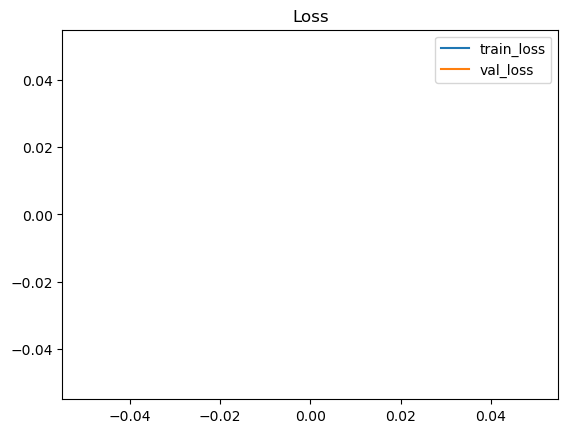

In [11]:
# Plot training history
plt.plot(hist['train_loss'], label='train_loss')
plt.plot(hist['val_loss'], label='val_loss')
plt.legend()
plt.title('Loss')
plt.savefig(os.path.join(save_dir, 'faster_rcnn_v2.png'))
plt.show()